In [1]:
%matplotlib notebook
import cvxpy as cp
import dccp
import torch
import numpy as np
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.metrics import zero_one_loss, confusion_matrix
from scipy.io import arff
import pandas as pd
import time
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils import shuffle
import matplotlib.patches as mpatches
import json
import random
import math
import os, psutil
from datetime import datetime

torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
np.random.seed(0)

XDIM = 29
TRAIN_SLOPE = 1
EVAL_SLOPE = 5
COST = 1./XDIM
EPSILON = 0.005
X_LOWER_BOUND = -10
X_UPPER_BOUND = 10

In [2]:
def visualize_data2D(X, Y):
    if not XDIM == 2:
        return
    
    Xpos = X[Y == 1]
    Xneg = X[Y == -1]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='green')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='purple')
    plt.show()
    
def visualize_weights(w1, b1, w2, b2):
    fig = plt.figure()
    plt.bar(np.arange(XDIM + 1), np.append(w1, b1), color='b', alpha=0.5)
    plt.bar(np.arange(XDIM + 1), np.append(w2, b2), color='r', alpha=0.5)
    plt.show()
    
def visualize_data3D(X, Y):
    if not XDIM == 3:
        return
    
    Xpos = X[Y == 1][:100]
    Xneg = X[Y == -1][:100]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Xpos[:, 0], Xpos[:, 1], Xpos[:, 2], marker='+', color='green')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], Xneg[:, 2], marker='_', color='purple')
    plt.show()
    
def visualize_data2D(X, Y):
    if not XDIM == 2:
        return
    
    Xpos = X[Y == 1]
    Xneg = X[Y == -1]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='green')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='purple')
    plt.show()
    
def visualize_data(X, Y):
    if XDIM == 2:
        visualize_data2D(X, Y)
    else:
        visualize_data3D(X, Y)
    
def visualize_strategic_data3D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic):
    if not XDIM == 3:
        return

    Xpos = Xval[Yval == 1][:50]
    Xneg = Xval[Yval == -1][:50]
    XposOpt = Xval_opt[Yval == 1][:50]
    XnegOpt = Xval_opt[Yval == -1][:50]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(Xpos[:, 0], Xpos[:, 1], Xpos[:, 2], marker='+', color='blue')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], Xneg[:, 2], marker='_', color='blue')

    ax.scatter(XposOpt[:, 0], XposOpt[:, 1], XposOpt[:, 2], marker='+', color='red')
    ax.scatter(XnegOpt[:, 0], XnegOpt[:, 1], XnegOpt[:, 2], marker='_', color='red')

    range_arr = torch.arange(-2, 2 + 1)
    xx, yy = torch.meshgrid(range_arr, range_arr)
    z = (-w_non_strategic[0] * xx - w_non_strategic[1] * yy - b_non_strategic) * 1. /w_non_strategic[2]
    ax.plot_surface(xx.numpy(), yy.numpy(), z.numpy(), alpha=0.2, color='blue')

    xx, yy = torch.meshgrid(range_arr, range_arr)
    z = (-w_strategic[0] * xx - w_strategic[1] * yy - b_strategic) * 1. /w_strategic[2]
    ax.plot_surface(xx.numpy(), yy.numpy(), z.numpy(), alpha=0.2, color='red')
#     ax.set_xlim3d(-1.2, 1.2)
#     ax.set_ylim3d(-1.2, 1.2)
#     ax.set_zlim3d(-1.2, 1.2)
#     ax.view_init(25, 45)
#     plt.savefig('plots/simple_strategic_classification.pdf', format='pdf')
#     plt.savefig('plots/simple_strategic_classification.eps', format='eps')
#     plt.savefig('plots/simple_strategic_classification.png', format='png')
    plt.show()

def visualize_strategic_data2D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic):
    if not XDIM == 2:
        return

    Xpos = Xval[Yval == 1][:50]
    Xneg = Xval[Yval == -1][:50]
    XposOpt = Xval_opt[Yval == 1][:50]
    XnegOpt = Xval_opt[Yval == -1][:50]

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='blue')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='blue')

    ax.scatter(XposOpt[:, 0], XposOpt[:, 1], marker='+', color='red')
    ax.scatter(XnegOpt[:, 0], XnegOpt[:, 1], marker='_', color='red')

    range_arr = torch.arange(-0.5, 2 + 1)
    xx = torch.meshgrid(range_arr)[0]
    z = (-w_non_strategic[0] * xx - b_non_strategic) * 1. /w_non_strategic[1]
    ax.plot(xx.detach().numpy(), z.detach().numpy(), alpha=0.2, color='blue')

    xx = torch.meshgrid(range_arr)[0]
    z = (-w_strategic[0] * xx - b_strategic) * 1. /w_strategic[1]
    ax.plot(xx.detach().numpy(), z.detach().numpy(), alpha=0.2, color='red')

    plt.show()
    
def visualize_strategic_data(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic):
    if XDIM == 2:
        visualize_strategic_data2D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic)
    else:
        visualize_strategic_data3D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic)
        
def visualize_training_errors(train_errors, val_errors):
    fig = plt.figure()
    train_patch, = plt.plot(torch.arange(len(train_errors)), np.mean(train_errors, axis=1), color='blue', label="train")
    val_patch, = plt.plot(torch.arange(len(val_errors)), val_errors, color='orange', label="validation")
    plt.legend(handles=[train_patch, val_patch])

    plt.show()
    
def visualize_training_losses(train_losses, val_losses):
    fig = plt.figure()
    train_patch, = plt.plot(torch.arange(len(train_losses)), np.mean(train_losses, axis=1), color='blue', label="train")
    val_patch, = plt.plot(torch.arange(len(val_losses)), val_losses, color='orange', label="validation")
    plt.legend(handles=[train_patch, val_patch])
    
    plt.show()

# Utils

In [3]:
def split_data(X, Y, percentage):
    num_val = int(len(X)*percentage)
    return X[num_val:], Y[num_val:], X[:num_val], Y[:num_val]

def shuffle(X, Y):
    data = torch.cat((X, Y), 1)
    data = data[torch.randperm(data.size()[0])]
    X = data[:, :2]
    Y = data[:, 2]
    return X, Y

def conf_mat(Y1, Y2):
    num_of_samples = len(Y1)
    mat = confusion_matrix(Y1, Y2, labels=[-1, 1])*100/num_of_samples
    acc = np.trace(mat)
    return mat, acc

def calc_accuracy(Y, Ypred):
    num = len(Y)
    temp = Y - Ypred
    acc = len(temp[temp == 0])*1./num
    return acc

# Dataset

In [4]:
def load_spam_dataset():
    torch.manual_seed(0)
    np.random.seed(0)

    path = r"C:\Users\sagil\Desktop\nir project\tip_spam_data\IS_journal_tip_spam.arff"
    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)
    most_disc = ['qTips_plc', 'rating_plc', 'qEmail_tip', 'qContacts_tip', 'qURL_tip', 'qPhone_tip', 'qNumeriChar_tip', 'sentistrength_tip', 'combined_tip', 'qWords_tip', 'followers_followees_gph', 'qunigram_avg_tip', 'qTips_usr', 'indeg_gph', 'qCapitalChar_tip', 'class1']
    df = df[most_disc]
    df["class1"].replace({b'spam': -1, b'notspam': 1}, inplace=True)
    df = df.sample(frac=1).reset_index(drop=True)

    Y = df['class1'].values
    X = df.drop('class1', axis = 1).values
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    return torch.from_numpy(X), torch.from_numpy(Y)

def load_card_fraud_data():
    torch.manual_seed(0)
    np.random.seed(0)
    df = pd.read_csv('C:/Users/sagil/Desktop/nir project/card_fraud_dataset/creditcard.csv')

    rob_scaler = RobustScaler()

    df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
    df.drop(['Time','Amount'], axis=1, inplace=True)
    scaled_amount = df['scaled_amount']
    df.drop(['scaled_amount'], axis=1, inplace=True)
    df.insert(0, 'scaled_amount', scaled_amount)

    df["Class"].replace({1: -1, 0: 1}, inplace=True)
    df = df.sample(frac=1).reset_index(drop=True)

    # amount of fraud classes 492 rows.
    fraud_df = df.loc[df['Class'] == -1]
    non_fraud_df = df.loc[df['Class'] == 1][:492]

    normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

    # Shuffle dataframe rows
    df = normal_distributed_df.sample(frac=1).reset_index(drop=True)

    Y = df['Class'].values
    X = df.drop('Class', axis = 1).values
    return torch.from_numpy(X), torch.from_numpy(Y)

def gen_custom_normal_data(N, pos_mean, pos_std, neg_mean, neg_std):
    torch.manual_seed(0)
    np.random.seed(0)
    pos_samples_num = N//2
    neg_samples_num = N - pos_samples_num
    posX = torch.randn((pos_samples_num, XDIM))*pos_std + pos_mean
    negX = torch.randn((neg_samples_num, XDIM))*neg_std + neg_mean
    
    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.ones(len(posX)), -torch.ones(len(negX))), 0), 1)

    X, Y = shuffle(X, Y)
    return X, Y

# CCP classes

In [5]:
class CCP:
    def __init__(self, x_dim, funcs):
        self.f_derivative = funcs["f_derivative"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.xt = cp.Parameter(x_dim)
        self.r = cp.Parameter(x_dim)
        self.w = cp.Parameter(x_dim)
        self.b = cp.Parameter(1)
        self.slope = cp.Parameter(1)
        self.v = cp.Parameter(x_dim)

        target = self.x@self.f_derivative(self.xt, self.w, self.b, self.slope)-self.g(self.x, self.w, self.b, self.slope)-self.c(self.x, self.r, self.v)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        self.prob = cp.Problem(cp.Maximize(target), constraints)
        
    def ccp(self, r):
        """
        numpy to numpy
        """
        self.xt.value = r
        self.r.value = r
        result = self.prob.solve()
        diff = np.linalg.norm(self.xt.value - self.x.value)
        cnt = 0
        while diff > 0.0001 and cnt < 10:
            cnt += 1
            self.xt.value = self.x.value
            result = self.prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)
        return self.x.value
    
    def optimize_X(self, X, w, b, slope, v):
        """
        tensor to tensor
        """
        w = w.detach().numpy()
        b = b.detach().numpy()
        v = v.detach().numpy()
        slope = np.full(1, slope)
        X = X.numpy()
        
        self.w.value = w
        self.b.value = b
        self.slope.value = slope
        self.v.value = v
        
        return torch.stack([torch.from_numpy(self.ccp(x)) for x in X])

In [6]:
class DELTA():
    
    def __init__(self, x_dim, funcs):
        self.g = funcs["g"]
        self.c = funcs["c_dpp_form"]
        
        self.x = cp.Variable(x_dim)
        self.r = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.w = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.v = cp.Parameter(XDIM, value = np.random.randn(XDIM))
        self.rv = cp.Parameter(1, value = np.random.randn(1)) # r times v
        self.f_der = cp.Parameter(x_dim, value = np.random.randn(x_dim))

        target = self.x@self.f_der-self.g(self.x, self.w, self.b, TRAIN_SLOPE)-self.c(self.x, self.r, self.v, self.rv)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        objective = cp.Maximize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.r, self.w, self.b, self.v, self.rv, self.f_der],
                                variables=[self.x])
        
    def optimize_X(self, X, w, b, v, F_DER):
        Rv = X@v
        Rv = torch.reshape(Rv, (Rv.size()[0], 1))
        return self.layer(X, w, b, v, Rv, F_DER)[0]

# Gain & Cost functions

In [7]:
def score(x, w, b):
    return x@w + b

def f(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) + 1)]), 2)

def g(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) - 1)]), 2)

def c(x, r, v):
    return COST*(EPSILON*cp.sum_squares(x-r) + (1-EPSILON)*cp.pos((x-r)@v)) # (1-EPSILON)*cp.sum(cp.pos(cp.multiply((x-r), v))))

def c_dpp_form(x, r, v, rv):
    return COST*(EPSILON*cp.sum_squares(x-r) + (1-EPSILON)*cp.pos(x@v-rv)) # (1-EPSILON)*cp.sum(cp.pos(cp.multiply(x, v)-rv)))

def f_derivative(x, w, b, slope):
    return 0.5*cp.multiply(slope*((slope*score(x, w, b) + 1)/cp.sqrt((slope*score(x, w, b) + 1)**2 + 1)), w)

funcs = {"f": f, "g": g, "f_derivative": f_derivative, "c": c, "c_dpp_form": c_dpp_form, "score": score}

# Data generation

In [8]:
N = 300
X, Y = gen_custom_normal_data(N, torch.Tensor([0.5, 0]), torch.Tensor([0.1, 1]), torch.Tensor([-0.5, 0]), torch.Tensor([0.1, 1]))

assert(len(X[0]) == XDIM)
X, Y, Xval, Yval = split_data(X, Y, 0.4)
Xval, Yval, Xtest, Ytest = split_data(Xval, Yval, 0.05)

print("percent of positive samples: {}%".format(100 * len(Y[Y == 1]) / len(Y)))
print("percent of positive samples: {}%".format(100 * len(Yval[Yval == 1]) / len(Yval)))
visualize_data(X, Y)
visualize_data(Xval, Yval)
visualize_data(Xtest, Ytest)

percent of positive samples: 46.666666666666664%
percent of positive samples: 44.73684210526316%


# Model

In [9]:
class MyStrategicModel(torch.nn.Module):
    def __init__(self, x_dim, funcs, train_slope, eval_slope, v_orig, strategic=False, flexible=False, lamb=0):
        torch.manual_seed(0)
        np.random.seed(0)
    
        super(MyStrategicModel, self).__init__()
        self.x_dim = x_dim
        self.train_slope, self.eval_slope = train_slope, eval_slope
        self.flexible = flexible
        self.strategic = strategic
        self.lamb = lamb
        
        self.w = torch.nn.parameter.Parameter(math.sqrt(1/x_dim)*(1-2*torch.rand(x_dim, dtype=torch.float64, requires_grad=True)))
        self.b = torch.nn.parameter.Parameter(torch.rand(1, dtype=torch.float64, requires_grad=True))
        self.v_orig = v_orig
        self.v = torch.clone(v_orig)
        if self.flexible:
            self.v = torch.nn.parameter.Parameter(torch.clone(v_orig), requires_grad=True)
        
        self.ccp = CCP(x_dim, funcs)
        self.delta = DELTA(x_dim, funcs)
        
    def forward(self, X, evaluation=False):
        slope = self.eval_slope if evaluation else self.train_slope
        
        if self.strategic:
            XT = self.ccp.optimize_X(X, self.w, self.b, slope, self.v)
            F_DER = self.get_f_ders(XT, slope)
            X_opt = self.delta.optimize_X(X, self.w, self.b, self.v, F_DER) # Xopt should equal to XT but we do it again for the gradients
            output = self.score(X_opt)
        else:
            output = self.score(X)        
        
        return output
    
    def optimize_X(self, X, evaluation=True):
        slope = self.eval_slope if evaluation else self.train_slope
        return self.ccp.optimize_X(X, self.w, self.b, slope, self.v)
    
    def score(self, x):
        return x@self.w + self.b
    
    def get_f_ders(self, XT, slope):
        return torch.stack([0.5*slope*((slope*self.score(xt) + 1)/torch.sqrt((slope*self.score(xt) + 1)**2 + 1))*self.w for xt in XT])

    def evaluate(self, X, Y):
        Y_pred = torch.sign(self.forward(X, evaluation=True))
        num = len(Y)
        temp = Y - Y_pred
        acc = len(temp[temp == 0])*1./num        
        return acc
    
    def loss(self, Y, Y_pred):
        if self.flexible:
            v_size = torch.norm(self.v)
            v_orig_size = torch.norm(self.v_orig)
            cos = (self.v*self.v_orig)/(v_size*v_orig_size)
            return (torch.mean(torch.clamp(1 - Y_pred * Y, min=0)) +
                    self.lamb*(torch.abs(v_size-v_orig_size) + 
                              torch.norm(cos-1)))
        else:
            return torch.mean(torch.clamp(1 - Y_pred * Y, min=0))
    
    def save_model(self, X, Y, Xval, Yval, Xtest, Ytest, train_errors, val_errors, train_losses, val_losses, info, path, comment=None):
        if comment is not None:
            path += "_____" + comment
            
        filename = path + "/model.pt"
        if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))
        torch.save(self.state_dict(), filename)
        
        pd.DataFrame(X.numpy()).to_csv(path + '/X.csv')
        pd.DataFrame(Y.numpy()).to_csv(path + '/Y.csv')
        pd.DataFrame(Xval.numpy()).to_csv(path + '/Xval.csv')
        pd.DataFrame(Yval.numpy()).to_csv(path + '/Yval.csv')
        pd.DataFrame(Xtest.numpy()).to_csv(path + '/Xtest.csv')
        pd.DataFrame(Ytest.numpy()).to_csv(path + '/Ytest.csv')
        
        pd.DataFrame(self.v.detach().numpy()).to_csv(path + '/v.csv')
        pd.DataFrame(self.v_orig.detach().numpy()).to_csv(path + '/v_orig.csv')
        pd.DataFrame(np.array(train_errors)).to_csv(path + '/train_errors.csv')
        pd.DataFrame(np.array(val_errors)).to_csv(path + '/val_errors.csv')
        pd.DataFrame(np.array(train_losses)).to_csv(path + '/train_losses.csv')
        pd.DataFrame(np.array(val_losses)).to_csv(path + '/val_losses.csv')
        
        with open(path + "/info.txt", "w") as f:
            f.write(info)
    
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()
    
    def fit(self, X, Y, Xval, Yval, Xtest, Ytest, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, verbose=False, callback=None, calc_train_errors=False, comment=None):
        train_dset = TensorDataset(X, Y)
        train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
        opt = opt(self.parameters(), **opt_kwargs)

        train_losses = []
        val_losses = []
        train_errors = []
        val_errors = []
        val_errors.append(1)
        val_losses.append(-1)
        
        best_val_error = 1
        consecutive_no_improvement = 0
        now = datetime.now()
        path = "C:/Users/sagil/Desktop/nir project/models/flexability/fraud_ex" + now.strftime("%d-%m-%Y_%H-%M-%S")

        total_time = time.time()
        for epoch in range(epochs):
            t1 = time.time()
            batch = 1
            train_losses.append([])
            train_errors.append([])
            for Xbatch, Ybatch in train_loader:
                try:
                    opt.zero_grad()
                    Ybatch_pred = self.forward(Xbatch)
                    l = self.loss(Ybatch_pred, Ybatch)
                    l.backward()
                    opt.step()
                    train_losses[-1].append(l.item())
                    if calc_train_errors:
                        with torch.no_grad():
                            e = self.evaluate(Xbatch, Ybatch)
                            train_errors[-1].append(1-e)
                    if verbose:
                        print("batch %03d / %03d | loss: %3.5f" %
                              (batch, len(train_loader), np.mean(train_losses[-1])))
                    batch += 1
                    if callback is not None:
                        callback()
                except:
                    print("failed")

            with torch.no_grad():
                try:
                    Yval_pred = self.forward(Xval, evaluation=True)
                    val_loss = self.loss(Yval_pred, Yval).item()
                    val_losses.append(val_loss)
                    val_error = 1-self.evaluate(Xval, Yval)
                    val_errors.append(val_error)
                    if val_error < best_val_error:
                        consecutive_no_improvement = 0
                        best_val_error = val_error
                        if self.strategic:
                            info = "training time in seconds: {}\nepoch: {}\nbatch size: {}\ntrain slope: {}\neval slope: {}\nlearning rate: {}\nlambda: {}\nvalidation loss: {}\nvalidation error: {}\n".format(
                            time.time()-total_time, epoch, batch_size, self.train_slope, self.eval_slope, opt_kwargs["lr"], self.lamb, val_loss, val_error)
                            self.save_model(X, Y, Xval, Yval, Xtest, Ytest, train_errors, val_errors, train_losses, val_losses, info, path, comment)
                            print("model saved!")
                    else:
                        consecutive_no_improvement += 1
                        if consecutive_no_improvement >= 10:
                            break
                except:
                    print("failed")
                    
            t2 = time.time()
            if verbose:
                print("----- epoch %03d / %03d | time: %03d sec | loss: %3.5f | err: %3.5f" % (epoch + 1, epochs, t2-t1, val_losses[-1], val_errors[-1]))
        print("training time: {} seconds".format(time.time()-total_time)) 
        return train_errors, val_errors, train_losses, val_losses

In [10]:
# EPOCHS = 12
# BATCH_SIZE = 32
# LAMBDA = 0.001

# x_dim = XDIM
# v_orig = torch.Tensor([-0.0083,  0.1438,  0.2624,  0.1383, -0.3927, -0.0812,  0.2853,  0.1248,
#          0.9651, -0.0347,  0.5332, -0.1104,  0.4133,  0.2955,  0.8981,  0.0175,
#         -0.1551,  0.5824, -0.3267,  0.0344,  0.5876,  0.8516, -0.4966,  0.8351,
#         -0.4504, -0.2245,  0.6009,  0.0764, -0.1217])

# v_orig /= torch.norm(v_orig, p=1)
# v_orig *= x_dim
# print(v_orig)

# torch.manual_seed(0)
# np.random.seed(0)
# v_0 = v_orig + 0.5*torch.randn(XDIM)
# for i in range(len(v_orig)):
#     if v_orig[i]*v_0[i] < 0: # different signs
#         v_0[i] = 0

# v_0 /= torch.norm(v_orig, p=1)
# v_0 *= x_dim
# print(v_0)


# Train

In [ ]:
EPOCHS = 12
BATCH_SIZE = 8
LAMBDA = 0.001

x_dim = XDIM
v_orig = torch.Tensor([-0.0083,  0.1438,  0.2624,  0.1383, -0.3927, -0.0812,  0.2853,  0.1248,
         0.9651, -0.0347,  0.5332, -0.1104,  0.4133,  0.2955,  0.8981,  0.0175,
        -0.1551,  0.5824, -0.3267,  0.0344,  0.5876,  0.8516, -0.4966,  0.8351,
        -0.4504, -0.2245,  0.6009,  0.0764, -0.1217])

v_orig /= torch.norm(v_orig, p=1)
v_orig *= x_dim
print(v_orig)

for i in range(20):
    torch.manual_seed(i)
    np.random.seed(i)
    v_0 = v_orig + 10*torch.randn(XDIM) + 10*torch.randn(XDIM)  + 10*torch.randn(XDIM)
#     for i in range(len(v_orig)):
#         if v_orig[i]*v_0[i] < 0: # different signs
#             v_0[i] = 0

    v_0 /= torch.norm(v_orig, p=1)
    v_0 *= x_dim
    print(v_0)

    # non-strategic classification
    print("---------- training non-strategically----------")
    non_strategic_model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, v_0, strategic=False, flexible=False)

    fit_res_non_strategic = non_strategic_model.fit(X, Y, Xval, Yval, Xtest, Ytest,
                                    opt=torch.optim.Adam, opt_kwargs={"lr": 5*(1e-2)},
                                    batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False)

    # strategic classification, fixed
    print("---------- training strategically----------")
    strategic_model_fixed = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, v_0, strategic=True, flexible=False)

    fit_res_strategic_fixed = strategic_model_fixed.fit(X, Y, Xval, Yval, Xtest, Ytest,
                                    opt=torch.optim.Adam, opt_kwargs={"lr": 5*(1e-2)},
                                    batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False,
                                    comment="fixed")
    print("------", strategic_model_fixed.v)

    # strategic classification, flexible
    print("---------- training strategically----------")
    strategic_model_flex = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, v_0, strategic=True, flexible=True, lamb=LAMBDA)

    fit_res_strategic_flex = strategic_model_flex.fit(X, Y, Xval, Yval, Xtest, Ytest,
                                    opt=torch.optim.Adam, opt_kwargs={"lr": 5*(1e-2)},
                                    batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False,
                                    comment="flexible")
    print("------", strategic_model_flex.v)

tensor([-0.0558,  0.8418, -0.6966,  1.3185, -1.9470, -0.0856,  0.8961,  1.1923,
        -0.0271,  0.7876,  1.3805, -0.2424,  1.6326, -0.0616,  1.2031,  2.3234,
         0.9437,  1.7611,  1.2938, -0.4039, -1.7553, -0.1088,  0.4391, -1.1420,
        -2.3501, -0.7009, -1.0475,  2.1728, -0.1890])
tensor([-17.1351, -13.8690,  -2.0803, -17.3828, -18.7991,  -1.6315, -17.9070,
         -7.1493, -23.0978, -16.7431,  26.5020,   5.7123, -21.5575, -14.3011,
         18.1331,   1.4522,  -7.0658,  13.9420,  -6.4748,  -3.9719, -13.1828,
         -4.1855,  -8.0579,  20.5896,   0.2347,   7.4902,  -7.7991,   4.9072,
         14.7936])
---------- training non-strategically----------
batch 001 / 008 | loss: 0.84591
batch 002 / 008 | loss: 0.49123
batch 003 / 008 | loss: 0.49357
batch 004 / 008 | loss: 0.54719
batch 005 / 008 | loss: 0.54000
batch 006 / 008 | loss: 0.46837
batch 007 / 008 | loss: 0.43139
batch 008 / 008 | loss: 0.42911
----- epoch 001 / 012 | time: 000 sec | loss: 0.34249 | err: 0.10526
ba

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l


batch 003 / 008 | loss: 0.02962
batch 004 / 008 | loss: 0.02222
batch 005 / 008 | loss: 0.01777
batch 006 / 008 | loss: 0.01481
batch 007 / 008 | loss: 0.01787
batch 008 / 008 | loss: 0.01563
----- epoch 008 / 012 | time: 000 sec | loss: 0.15725 | err: 0.05263
batch 001 / 008 | loss: 0.00528
batch 002 / 008 | loss: 0.00264
batch 003 / 008 | loss: 0.01222
batch 004 / 008 | loss: 0.01382
batch 005 / 008 | loss: 0.01106
batch 006 / 008 | loss: 0.01689
batch 007 / 008 | loss: 0.01447
batch 008 / 008 | loss: 0.01267
----- epoch 009 / 012 | time: 000 sec | loss: 0.16740 | err: 0.05263
batch 001 / 008 | loss: 0.01002
batch 002 / 008 | loss: 0.00501
batch 003 / 008 | loss: 0.00334
batch 004 / 008 | loss: 0.00250
batch 005 / 008 | loss: 0.00200
batch 006 / 008 | loss: 0.00167
batch 007 / 008 | loss: 0.00143
batch 008 / 008 | loss: 0.01822
----- epoch 010 / 012 | time: 000 sec | loss: 0.17250 | err: 0.05263
batch 001 / 008 | loss: 0.00000
batch 002 / 008 | loss: 0.01714
batch 003 / 008 | loss: 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 008 | loss: 2.22937
batch 002 / 008 | loss: 2.92207
batch 003 / 008 | loss: 2.69024
batch 004 / 008 | loss: 2.42048
batch 005 / 008 | loss: 2.24969
batch 006 / 008 | loss: 2.23646
batch 007 / 008 | loss: 2.29964
batch 008 / 008 | loss: 2.41044
model saved!
----- epoch 001 / 012 | time: 051 sec | loss: 2.00829 | err: 0.44737
batch 001 / 008 | loss: 2.34457
batch 002 / 008 | loss: 1.98357
batch 003 / 008 | loss: 1.95855
batch 004 / 008 | loss: 1.86607
batch 005 / 008 | loss: 1.90388
batch 006 / 008 | loss: 1.77553
batch 007 / 008 | loss: 1.67818
batch 008 / 008 | loss: 1.71136
----- epoch 002 / 012 | time: 044 sec | loss: 1.44244 | err: 0.55263
batch 001 / 008 | loss: 0.64809
batch 002 / 008 | loss: 1.45844
batch 003 / 008 | loss: 1.23129
batch 004 / 008 | loss: 1.37981
batch 005 / 008 | loss: 1.36451
batch 006 / 008 | loss: 1.36684
batch 007 / 008 | loss: 1.35338
batch 008 / 008 | loss: 1.38131
----- epoch 003 / 012 | time: 047 sec | loss: 1.17098 | err: 0.47368
batch 001 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 008 | loss: 2.23457
batch 002 / 008 | loss: 2.92705
batch 003 / 008 | loss: 2.69482
batch 004 / 008 | loss: 2.42494
batch 005 / 008 | loss: 2.25436
batch 006 / 008 | loss: 2.24123
batch 007 / 008 | loss: 2.30440
batch 008 / 008 | loss: 2.41504
model saved!
----- epoch 001 / 012 | time: 048 sec | loss: 2.00852 | err: 0.39474
batch 001 / 008 | loss: 2.34516
batch 002 / 008 | loss: 1.98437
batch 003 / 008 | loss: 1.95920
batch 004 / 008 | loss: 1.86745
batch 005 / 008 | loss: 1.90541
batch 006 / 008 | loss: 1.77681
batch 007 / 008 | loss: 1.67858
batch 008 / 008 | loss: 1.71013
----- epoch 002 / 012 | time: 046 sec | loss: 1.44522 | err: 0.55263
batch 001 / 008 | loss: 0.65048
batch 002 / 008 | loss: 1.46039
batch 003 / 008 | loss: 1.23546
batch 004 / 008 | loss: 1.37930
batch 005 / 008 | loss: 1.36104
batch 006 / 008 | loss: 1.35695
batch 007 / 008 | loss: 1.33656
batch 008 / 008 | loss: 1.36996
----- epoch 003 / 012 | time: 041 sec | loss: 1.05858 | err: 0.50000
batch 001 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 008 / 008 | loss: 0.01563
----- epoch 008 / 012 | time: 000 sec | loss: 0.15725 | err: 0.05263
batch 001 / 008 | loss: 0.00528
batch 002 / 008 | loss: 0.00264
batch 003 / 008 | loss: 0.01222
batch 004 / 008 | loss: 0.01382
batch 005 / 008 | loss: 0.01106
batch 006 / 008 | loss: 0.01689
batch 007 / 008 | loss: 0.01447
batch 008 / 008 | loss: 0.01267
----- epoch 009 / 012 | time: 000 sec | loss: 0.16740 | err: 0.05263
batch 001 / 008 | loss: 0.01002
batch 002 / 008 | loss: 0.00501
batch 003 / 008 | loss: 0.00334
batch 004 / 008 | loss: 0.00250
batch 005 / 008 | loss: 0.00200
batch 006 / 008 | loss: 0.00167
batch 007 / 008 | loss: 0.00143
batch 008 / 008 | loss: 0.01822
----- epoch 010 / 012 | time: 000 sec | loss: 0.17250 | err: 0.05263
batch 001 / 008 | loss: 0.00000
batch 002 / 008 | loss: 0.01714
batch 003 / 008 | loss: 0.01243
batch 004 / 008 | loss: 0.01376
batch 005 / 008 | loss: 0.01101
batch 006 / 008 | loss: 0.00918
batch 007 / 008 | loss: 0.00787
batch 008 / 008 | loss: 0

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 008 | loss: 2.23273


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 002 / 008 | loss: 2.93225
batch 003 / 008 | loss: 2.72405
batch 004 / 008 | loss: 2.46440
batch 005 / 008 | loss: 2.19926
batch 006 / 008 | loss: 2.20186
batch 007 / 008 | loss: 2.27561
batch 008 / 008 | loss: 2.40141
model saved!
----- epoch 001 / 012 | time: 049 sec | loss: 2.09980 | err: 0.44737
batch 001 / 008 | loss: 2.44603
batch 002 / 008 | loss: 2.09856
batch 003 / 008 | loss: 2.08806
batch 004 / 008 | loss: 1.95031
batch 005 / 008 | loss: 1.96961
batch 006 / 008 | loss: 1.83422
batch 007 / 008 | loss: 1.73198
batch 008 / 008 | loss: 1.79330
----- epoch 002 / 012 | time: 042 sec | loss: 1.42412 | err: 0.55263
batch 001 / 008 | loss: 0.63761
batch 002 / 008 | loss: 1.28258
batch 003 / 008 | loss: 1.03512
batch 004 / 008 | loss: 1.17343
batch 005 / 008 | loss: 1.17821
batch 006 / 008 | loss: 1.22071
batch 007 / 008 | loss: 1.22270
batch 008 / 008 | loss: 1.25885
----- epoch 003 / 012 | time: 040 sec | loss: 1.25567 | err: 0.55263
batch 001 / 008 | loss: 1.42389
batch 002 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 008 | loss: 2.23794
batch 002 / 008 | loss: 2.93749
batch 003 / 008 | loss: 2.72915
batch 004 / 008 | loss: 2.46942


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 005 / 008 | loss: 2.20431
batch 006 / 008 | loss: 2.20701
batch 007 / 008 | loss: 2.28083
batch 008 / 008 | loss: 2.40664
model saved!
----- epoch 001 / 012 | time: 053 sec | loss: 2.10539 | err: 0.44737
batch 001 / 008 | loss: 2.45169
batch 002 / 008 | loss: 2.10451
batch 003 / 008 | loss: 2.09380
batch 004 / 008 | loss: 1.95612
batch 005 / 008 | loss: 1.97542
batch 006 / 008 | loss: 1.83989
batch 007 / 008 | loss: 1.73762
batch 008 / 008 | loss: 1.79881
----- epoch 002 / 012 | time: 042 sec | loss: 1.43069 | err: 0.55263
batch 001 / 008 | loss: 0.64336
batch 002 / 008 | loss: 1.29196
batch 003 / 008 | loss: 1.04429
batch 004 / 008 | loss: 1.18719
batch 005 / 008 | loss: 1.18762
batch 006 / 008 | loss: 1.21664
batch 007 / 008 | loss: 1.23035
batch 008 / 008 | loss: 1.27186
model saved!
----- epoch 003 / 012 | time: 042 sec | loss: 1.15122 | err: 0.34211
batch 001 / 008 | loss: 1.32025
batch 002 / 008 | loss: 1.22750
batch 003 / 008 | loss: 1.18287
batch 004 / 008 | loss: 1.16081

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l


batch 003 / 008 | loss: 0.02962
batch 004 / 008 | loss: 0.02222
batch 005 / 008 | loss: 0.01777
batch 006 / 008 | loss: 0.01481
batch 007 / 008 | loss: 0.01787
batch 008 / 008 | loss: 0.01563
----- epoch 008 / 012 | time: 000 sec | loss: 0.15725 | err: 0.05263
batch 001 / 008 | loss: 0.00528
batch 002 / 008 | loss: 0.00264
batch 003 / 008 | loss: 0.01222
batch 004 / 008 | loss: 0.01382
batch 005 / 008 | loss: 0.01106
batch 006 / 008 | loss: 0.01689
batch 007 / 008 | loss: 0.01447
batch 008 / 008 | loss: 0.01267
----- epoch 009 / 012 | time: 000 sec | loss: 0.16740 | err: 0.05263
batch 001 / 008 | loss: 0.01002
batch 002 / 008 | loss: 0.00501
batch 003 / 008 | loss: 0.00334
batch 004 / 008 | loss: 0.00250
batch 005 / 008 | loss: 0.00200
batch 006 / 008 | loss: 0.00167
batch 007 / 008 | loss: 0.00143
batch 008 / 008 | loss: 0.01822
----- epoch 010 / 012 | time: 000 sec | loss: 0.17250 | err: 0.05263
batch 001 / 008 | loss: 0.00000
batch 002 / 008 | loss: 0.01714
batch 003 / 008 | loss: 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 008 | loss: 2.22945
batch 002 / 008 | loss: 2.95736
batch 003 / 008 | loss: 2.75296
batch 004 / 008 | loss: 2.49604


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 005 / 008 | loss: 2.22889
batch 006 / 008 | loss: 2.23100
batch 007 / 008 | loss: 2.30397
batch 008 / 008 | loss: 2.42826
model saved!
----- epoch 001 / 012 | time: 053 sec | loss: 2.11512 | err: 0.44737
batch 001 / 008 | loss: 2.46844
batch 002 / 008 | loss: 2.10348
batch 003 / 008 | loss: 2.07077
batch 004 / 008 | loss: 1.93835
batch 005 / 008 | loss: 1.96234
batch 006 / 008 | loss: 1.82964
batch 007 / 008 | loss: 1.73607
batch 008 / 008 | loss: 1.78884
----- epoch 002 / 012 | time: 046 sec | loss: 1.43058 | err: 0.55263
batch 001 / 008 | loss: 0.64408
batch 002 / 008 | loss: 1.43527
batch 003 / 008 | loss: 1.18455
batch 004 / 008 | loss: 1.35016
batch 005 / 008 | loss: 1.33504
batch 006 / 008 | loss: 1.34648
batch 007 / 008 | loss: 1.35618
batch 008 / 008 | loss: 1.41604
----- epoch 003 / 012 | time: 039 sec | loss: 1.25713 | err: 0.55263
batch 001 / 008 | loss: 1.45643
batch 002 / 008 | loss: 1.21714
batch 003 / 008 | loss: 1.18885
batch 004 / 008 | loss: 1.23934
batch 005 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 008 | loss: 2.23465
batch 002 / 008 | loss: 2.96240
batch 003 / 008 | loss: 2.75767
batch 004 / 008 | loss: 2.50061


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 005 / 008 | loss: 2.23347
batch 006 / 008 | loss: 2.23567
batch 007 / 008 | loss: 2.30873
batch 008 / 008 | loss: 2.43271
model saved!
----- epoch 001 / 012 | time: 056 sec | loss: 2.11849 | err: 0.44737
batch 001 / 008 | loss: 2.47141
batch 002 / 008 | loss: 2.10701
batch 003 / 008 | loss: 2.07401
batch 004 / 008 | loss: 1.94168
batch 005 / 008 | loss: 1.96506
batch 006 / 008 | loss: 1.83235
batch 007 / 008 | loss: 1.73966
batch 008 / 008 | loss: 1.79310
----- epoch 002 / 012 | time: 052 sec | loss: 1.44377 | err: 0.55263
batch 001 / 008 | loss: 0.65417
batch 002 / 008 | loss: 1.44807
batch 003 / 008 | loss: 1.19689
batch 004 / 008 | loss: 1.36645
batch 005 / 008 | loss: 1.35677
batch 006 / 008 | loss: 1.36877
batch 007 / 008 | loss: 1.36668
batch 008 / 008 | loss: 1.42457
----- epoch 003 / 012 | time: 048 sec | loss: 1.30095 | err: 0.55263
batch 001 / 008 | loss: 1.49994
batch 002 / 008 | loss: 1.26247
batch 003 / 008 | loss: 1.22785
batch 004 / 008 | loss: 1.27977
batch 005 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 005 / 008 | loss: 0.01777
batch 006 / 008 | loss: 0.01481
batch 007 / 008 | loss: 0.01787
batch 008 / 008 | loss: 0.01563
----- epoch 008 / 012 | time: 000 sec | loss: 0.15725 | err: 0.05263
batch 001 / 008 | loss: 0.00528
batch 002 / 008 | loss: 0.00264
batch 003 / 008 | loss: 0.01222
batch 004 / 008 | loss: 0.01382
batch 005 / 008 | loss: 0.01106
batch 006 / 008 | loss: 0.01689
batch 007 / 008 | loss: 0.01447
batch 008 / 008 | loss: 0.01267
----- epoch 009 / 012 | time: 000 sec | loss: 0.16740 | err: 0.05263
batch 001 / 008 | loss: 0.01002
batch 002 / 008 | loss: 0.00501
batch 003 / 008 | loss: 0.00334
batch 004 / 008 | loss: 0.00250
batch 005 / 008 | loss: 0.00200
batch 006 / 008 | loss: 0.00167
batch 007 / 008 | loss: 0.00143
batch 008 / 008 | loss: 0.01822
----- epoch 010 / 012 | time: 000 sec | loss: 0.17250 | err: 0.05263
batch 001 / 008 | loss: 0.00000
batch 002 / 008 | loss: 0.01714
batch 003 / 008 | loss: 0.01243
batch 004 / 008 | loss: 0.01376
batch 005 / 008 | loss: 0

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 008 | loss: 2.23067
batch 002 / 008 | loss: 2.95401
batch 003 / 008 | loss: 2.76105
batch 004 / 008 | loss: 2.50795
batch 005 / 008 | loss: 2.23995
batch 006 / 008 | loss: 2.23989


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 007 / 008 | loss: 2.31213
batch 008 / 008 | loss: 2.43917
model saved!
----- epoch 001 / 012 | time: 057 sec | loss: 2.10695 | err: 0.47368
batch 001 / 008 | loss: 2.45046
batch 002 / 008 | loss: 2.07595
batch 003 / 008 | loss: 2.06041
batch 004 / 008 | loss: 1.92604
batch 005 / 008 | loss: 1.94368
batch 006 / 008 | loss: 1.80990
batch 007 / 008 | loss: 1.71485
batch 008 / 008 | loss: 1.79185
----- epoch 002 / 012 | time: 046 sec | loss: 1.60527 | err: 0.55263
batch 001 / 008 | loss: 0.71727
batch 002 / 008 | loss: 1.41248
batch 003 / 008 | loss: 1.12691
batch 004 / 008 | loss: 1.26104
batch 005 / 008 | loss: 1.25231
batch 006 / 008 | loss: 1.29121
batch 007 / 008 | loss: 1.30815
batch 008 / 008 | loss: 1.35598
----- epoch 003 / 012 | time: 051 sec | loss: 1.16078 | err: 0.52632
batch 001 / 008 | loss: 1.32309
batch 002 / 008 | loss: 1.15331
batch 003 / 008 | loss: 1.12355
batch 004 / 008 | loss: 1.16520
batch 005 / 008 | loss: 1.16155
batch 006 / 008 | loss: 1.10081
batch 007 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 008 | loss: 2.23587


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 002 / 008 | loss: 2.95898
batch 003 / 008 | loss: 2.76590
batch 004 / 008 | loss: 2.51271
batch 005 / 008 | loss: 2.24468
batch 006 / 008 | loss: 2.24458
batch 007 / 008 | loss: 2.31677
batch 008 / 008 | loss: 2.44347
model saved!
----- epoch 001 / 012 | time: 066 sec | loss: 2.10942 | err: 0.47368
batch 001 / 008 | loss: 2.45239
batch 002 / 008 | loss: 2.07850
batch 003 / 008 | loss: 2.06342
batch 004 / 008 | loss: 1.92909
batch 005 / 008 | loss: 1.94655
batch 006 / 008 | loss: 1.81169
batch 007 / 008 | loss: 1.71720
batch 008 / 008 | loss: 1.79662
----- epoch 002 / 012 | time: 054 sec | loss: 1.62192 | err: 0.55263
batch 001 / 008 | loss: 0.72704
batch 002 / 008 | loss: 1.41860
batch 003 / 008 | loss: 1.12278
batch 004 / 008 | loss: 1.25968
batch 005 / 008 | loss: 1.25584
batch 006 / 008 | loss: 1.29303
batch 007 / 008 | loss: 1.30177
batch 008 / 008 | loss: 1.36529
----- epoch 003 / 012 | time: 051 sec | loss: 1.29746 | err: 0.55263
batch 001 / 008 | loss: 1.46109
batch 002 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l


batch 005 / 008 | loss: 0.02951
batch 006 / 008 | loss: 0.05484
batch 007 / 008 | loss: 0.05886
batch 008 / 008 | loss: 0.05151
----- epoch 005 / 012 | time: 000 sec | loss: 0.15350 | err: 0.05263
batch 001 / 008 | loss: 0.00000
batch 002 / 008 | loss: 0.04774
batch 003 / 008 | loss: 0.03183
batch 004 / 008 | loss: 0.06670
batch 005 / 008 | loss: 0.05336
batch 006 / 008 | loss: 0.04447
batch 007 / 008 | loss: 0.03842
batch 008 / 008 | loss: 0.03362
----- epoch 006 / 012 | time: 000 sec | loss: 0.15926 | err: 0.05263
batch 001 / 008 | loss: 0.03612
batch 002 / 008 | loss: 0.03111
batch 003 / 008 | loss: 0.02074
batch 004 / 008 | loss: 0.02041
batch 005 / 008 | loss: 0.01633
batch 006 / 008 | loss: 0.01376
batch 007 / 008 | loss: 0.02570
batch 008 / 008 | loss: 0.02249
----- epoch 007 / 012 | time: 000 sec | loss: 0.14896 | err: 0.05263
batch 001 / 008 | loss: 0.08887
batch 002 / 008 | loss: 0.04443
batch 003 / 008 | loss: 0.02962
batch 004 / 008 | loss: 0.02222
batch 005 / 008 | loss: 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 008 | loss: 2.22581
batch 002 / 008 | loss: 2.92094
batch 003 / 008 | loss: 2.73339
batch 004 / 008 | loss: 2.49421


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 005 / 008 | loss: 2.23051
batch 006 / 008 | loss: 2.13400
batch 007 / 008 | loss: 1.98371
batch 008 / 008 | loss: 2.17054
model saved!
----- epoch 001 / 012 | time: 067 sec | loss: 1.63903 | err: 0.15789
batch 001 / 008 | loss: 2.63982
batch 002 / 008 | loss: 1.98019
batch 003 / 008 | loss: 1.72524
batch 004 / 008 | loss: 1.29393
batch 005 / 008 | loss: 1.19367
batch 006 / 008 | loss: 1.13852
batch 007 / 008 | loss: 1.02564
batch 008 / 008 | loss: 1.11027
model saved!
----- epoch 002 / 012 | time: 049 sec | loss: 0.87258 | err: 0.10526
batch 001 / 008 | loss: 0.00000
batch 002 / 008 | loss: 0.61487
batch 003 / 008 | loss: 0.40991
batch 004 / 008 | loss: 0.53953
batch 005 / 008 | loss: 0.48830
batch 006 / 008 | loss: 0.45349
batch 007 / 008 | loss: 0.56904
batch 008 / 008 | loss: 0.58872
----- epoch 003 / 012 | time: 040 sec | loss: 0.35395 | err: 0.18421
batch 001 / 008 | loss: 0.29140
batch 002 / 008 | loss: 0.59890
batch 003 / 008 | loss: 0.39927
batch 004 / 008 | loss: 0.29945

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 008 | loss: 2.23101
batch 002 / 008 | loss: 2.92562
batch 003 / 008 | loss: 2.74036
batch 004 / 008 | loss: 2.50291


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 005 / 008 | loss: 2.23987
batch 006 / 008 | loss: 2.14402
batch 007 / 008 | loss: 1.99382
batch 008 / 008 | loss: 2.18300
model saved!
----- epoch 001 / 012 | time: 051 sec | loss: 1.65566 | err: 0.15789
batch 001 / 008 | loss: 2.66718
batch 002 / 008 | loss: 2.00228
batch 003 / 008 | loss: 1.74472
batch 004 / 008 | loss: 1.30986
batch 005 / 008 | loss: 1.20601
batch 006 / 008 | loss: 1.14763
batch 007 / 008 | loss: 1.03035
batch 008 / 008 | loss: 1.10844
model saved!
----- epoch 002 / 012 | time: 041 sec | loss: 0.84068 | err: 0.10526
batch 001 / 008 | loss: 0.00531
batch 002 / 008 | loss: 0.59275
batch 003 / 008 | loss: 0.39693
batch 004 / 008 | loss: 0.42719
batch 005 / 008 | loss: 0.39959
batch 006 / 008 | loss: 0.38538
batch 007 / 008 | loss: 0.51752
batch 008 / 008 | loss: 0.53215
----- epoch 003 / 012 | time: 035 sec | loss: 0.26911 | err: 0.18421
batch 001 / 008 | loss: 0.12650
batch 002 / 008 | loss: 0.55168
batch 003 / 008 | loss: 0.36953
batch 004 / 008 | loss: 0.27845

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l


batch 001 / 008 | loss: 0.00528
batch 002 / 008 | loss: 0.00264
batch 003 / 008 | loss: 0.01222
batch 004 / 008 | loss: 0.01382
batch 005 / 008 | loss: 0.01106
batch 006 / 008 | loss: 0.01689
batch 007 / 008 | loss: 0.01447
batch 008 / 008 | loss: 0.01267
----- epoch 009 / 012 | time: 000 sec | loss: 0.16740 | err: 0.05263
batch 001 / 008 | loss: 0.01002
batch 002 / 008 | loss: 0.00501
batch 003 / 008 | loss: 0.00334
batch 004 / 008 | loss: 0.00250
batch 005 / 008 | loss: 0.00200
batch 006 / 008 | loss: 0.00167
batch 007 / 008 | loss: 0.00143
batch 008 / 008 | loss: 0.01822
----- epoch 010 / 012 | time: 000 sec | loss: 0.17250 | err: 0.05263
batch 001 / 008 | loss: 0.00000
batch 002 / 008 | loss: 0.01714
batch 003 / 008 | loss: 0.01243
batch 004 / 008 | loss: 0.01376
batch 005 / 008 | loss: 0.01101
batch 006 / 008 | loss: 0.00918
batch 007 / 008 | loss: 0.00787
batch 008 / 008 | loss: 0.00688
----- epoch 011 / 012 | time: 000 sec | loss: 0.21264 | err: 0.10526
batch 001 / 008 | loss: 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 008 | loss: 2.21765
batch 002 / 008 | loss: 2.94339


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 003 / 008 | loss: 2.75604
batch 004 / 008 | loss: 2.50822
batch 005 / 008 | loss: 2.24348
batch 006 / 008 | loss: 2.24588
batch 007 / 008 | loss: 2.32086
batch 008 / 008 | loss: 2.45706
model saved!
----- epoch 001 / 012 | time: 053 sec | loss: 2.19568 | err: 0.34211
batch 001 / 008 | loss: 2.56889
batch 002 / 008 | loss: 2.19895
batch 003 / 008 | loss: 2.16426
batch 004 / 008 | loss: 2.01349
batch 005 / 008 | loss: 2.03032
batch 006 / 008 | loss: 1.89610
batch 007 / 008 | loss: 1.79803
batch 008 / 008 | loss: 1.85800
----- epoch 002 / 012 | time: 039 sec | loss: 1.48952 | err: 0.55263
batch 001 / 008 | loss: 0.67837
batch 002 / 008 | loss: 1.38074
batch 003 / 008 | loss: 1.15748
batch 004 / 008 | loss: 1.31333
batch 005 / 008 | loss: 1.30869
batch 006 / 008 | loss: 1.31312
batch 007 / 008 | loss: 1.33578
batch 008 / 008 | loss: 1.41207
----- epoch 003 / 012 | time: 040 sec | loss: 1.37551 | err: 0.55263
batch 001 / 008 | loss: 1.56246
batch 002 / 008 | loss: 1.31900
batch 003 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 008 | loss: 2.22286
batch 002 / 008 | loss: 2.94840
batch 003 / 008 | loss: 2.76128
batch 004 / 008 | loss: 2.51378
batch 005 / 008 | loss: 2.24903
batch 006 / 008 | loss: 2.25089


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 007 / 008 | loss: 2.32538
batch 008 / 008 | loss: 2.46103
model saved!
----- epoch 001 / 012 | time: 058 sec | loss: 2.19588 | err: 0.34211
batch 001 / 008 | loss: 2.56706
batch 002 / 008 | loss: 2.19583
batch 003 / 008 | loss: 2.16069
batch 004 / 008 | loss: 2.01163
batch 005 / 008 | loss: 2.02741
batch 006 / 008 | loss: 1.89286
batch 007 / 008 | loss: 1.79416
batch 008 / 008 | loss: 1.85467
----- epoch 002 / 012 | time: 044 sec | loss: 1.47019 | err: 0.55263
batch 001 / 008 | loss: 0.67152
batch 002 / 008 | loss: 1.37404
batch 003 / 008 | loss: 1.14675
batch 004 / 008 | loss: 1.30251
batch 005 / 008 | loss: 1.29524
batch 006 / 008 | loss: 1.31325
batch 007 / 008 | loss: 1.30144
batch 008 / 008 | loss: 1.38423
----- epoch 003 / 012 | time: 048 sec | loss: 1.35907 | err: 0.55263
batch 001 / 008 | loss: 1.53974
batch 002 / 008 | loss: 1.28223
batch 003 / 008 | loss: 1.18181
batch 004 / 008 | loss: 1.26964
batch 005 / 008 | loss: 1.29716
batch 006 / 008 | loss: 1.20621
batch 007 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 008 | loss: 0.08887
batch 002 / 008 | loss: 0.04443
batch 003 / 008 | loss: 0.02962
batch 004 / 008 | loss: 0.02222
batch 005 / 008 | loss: 0.01777
batch 006 / 008 | loss: 0.01481
batch 007 / 008 | loss: 0.01787
batch 008 / 008 | loss: 0.01563
----- epoch 008 / 012 | time: 000 sec | loss: 0.15725 | err: 0.05263
batch 001 / 008 | loss: 0.00528
batch 002 / 008 | loss: 0.00264
batch 003 / 008 | loss: 0.01222
batch 004 / 008 | loss: 0.01382
batch 005 / 008 | loss: 0.01106
batch 006 / 008 | loss: 0.01689
batch 007 / 008 | loss: 0.01447
batch 008 / 008 | loss: 0.01267
----- epoch 009 / 012 | time: 000 sec | loss: 0.16740 | err: 0.05263
batch 001 / 008 | loss: 0.01002
batch 002 / 008 | loss: 0.00501
batch 003 / 008 | loss: 0.00334
batch 004 / 008 | loss: 0.00250
batch 005 / 008 | loss: 0.00200
batch 006 / 008 | loss: 0.00167
batch 007 / 008 | loss: 0.00143
batch 008 / 008 | loss: 0.01822
----- epoch 010 / 012 | time: 000 sec | loss: 0.17250 | err: 0.05263
batch 001 / 008 | loss: 0

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 008 | loss: 2.23284
batch 002 / 008 | loss: 2.96410
batch 003 / 008 | loss: 2.75644
batch 004 / 008 | loss: 2.49463


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 005 / 008 | loss: 2.22601
batch 006 / 008 | loss: 2.22529
batch 007 / 008 | loss: 2.29808
batch 008 / 008 | loss: 2.42742
model saved!
----- epoch 001 / 012 | time: 053 sec | loss: 2.14553 | err: 0.42105
batch 001 / 008 | loss: 2.49996
batch 002 / 008 | loss: 2.14168
batch 003 / 008 | loss: 2.11348
batch 004 / 008 | loss: 1.97041
batch 005 / 008 | loss: 1.98652
batch 006 / 008 | loss: 1.85079
batch 007 / 008 | loss: 1.75153
batch 008 / 008 | loss: 1.80943
----- epoch 002 / 012 | time: 047 sec | loss: 1.44070 | err: 0.55263
batch 001 / 008 | loss: 0.65820
batch 002 / 008 | loss: 1.37671
batch 003 / 008 | loss: 1.10346
batch 004 / 008 | loss: 1.24848
batch 005 / 008 | loss: 1.20870
batch 006 / 008 | loss: 1.25476
batch 007 / 008 | loss: 1.29293
batch 008 / 008 | loss: 1.33073
----- epoch 003 / 012 | time: 050 sec | loss: 1.16596 | err: 0.55263
batch 001 / 008 | loss: 1.35055
batch 002 / 008 | loss: 1.25005
batch 003 / 008 | loss: 1.16380
batch 004 / 008 | loss: 1.22534
batch 005 / 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 008 | loss: 2.23804
batch 002 / 008 | loss: 2.96928


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 003 / 008 | loss: 2.76168
batch 004 / 008 | loss: 2.49985
batch 005 / 008 | loss: 2.23123
batch 006 / 008 | loss: 2.23053
batch 007 / 008 | loss: 2.30342
batch 008 / 008 | loss: 2.43289
model saved!
----- epoch 001 / 012 | time: 048 sec | loss: 2.15190 | err: 0.42105
batch 001 / 008 | loss: 2.50659
batch 002 / 008 | loss: 2.14805
batch 003 / 008 | loss: 2.11984
batch 004 / 008 | loss: 1.97682
batch 005 / 008 | loss: 1.99307
batch 006 / 008 | loss: 1.85786
batch 007 / 008 | loss: 1.75790
batch 008 / 008 | loss: 1.81534
----- epoch 002 / 012 | time: 037 sec | loss: 1.44601 | err: 0.55263
batch 001 / 008 | loss: 0.66363
batch 002 / 008 | loss: 1.39275
batch 003 / 008 | loss: 1.11539
batch 004 / 008 | loss: 1.25722
batch 005 / 008 | loss: 1.22348
batch 006 / 008 | loss: 1.25306
batch 007 / 008 | loss: 1.28931
batch 008 / 008 | loss: 1.33736
----- epoch 003 / 012 | time: 031 sec | loss: 1.11559 | err: 0.55263
batch 001 / 008 | loss: 1.26531
batch 002 / 008 | loss: 1.25917
batch 003 / 

In [ ]:
print(non_strategic_model.w, non_strategic_model.b)

# Test results

In [14]:
# strategic_model_flex = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, v_orig, strategic=True, flexible=True, lamb=LAMBDA)
# strategic_model_flex.load_model(r"C:\Users\sagil\Desktop\nir project\models\flexability\20-01-2021_15-56-32_____flexible\model.pt")

# strategic_model_not_flex = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, v_orig, strategic=True, flexible=False)
# strategic_model_not_flex.load_model(r"C:\Users\sagil\Desktop\nir project\models\flexability\20-01-2021_16-16-16_____fixed\model.pt")

# Xval_opt = non_strategic_model.optimize_X(Xval, evaluation=True)
# Xval_opt_flex = strategic_model_flex.optimize_X(Xval, evaluation=True)
# Xval_opt_not_flex = strategic_model_not_flex.optimize_X(Xval, evaluation=True)

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

In [15]:
print("non strategic model + non strategic data: ", non_strategic_model.evaluate(Xval, Yval))
print("non strategic model + strategic data: ", non_strategic_model.evaluate(Xval_opt, Yval))
print("flexible strategic model + strategic data: ", strategic_model_flex.evaluate(Xval, Yval))
print("fixed strategic model + strategic data: ", strategic_model_not_flex.evaluate(Xval, Yval))

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


non strategic model + non strategic data:  0.992
non strategic model + strategic data:  0.544
flexible strategic model + strategic data:  0.984
fixed strategic model + strategic data:  0.848


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


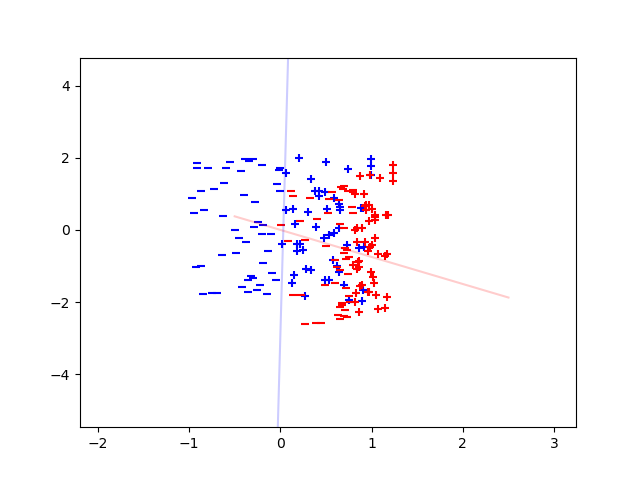

In [19]:
visualize_strategic_data(Xval, Xval_opt, Yval, non_strategic_model.w, non_strategic_model.b, non_strategic_model.v, torch.zeros(1))

Parameter containing:
tensor([0.0316, 0.0060], requires_grad=True)


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


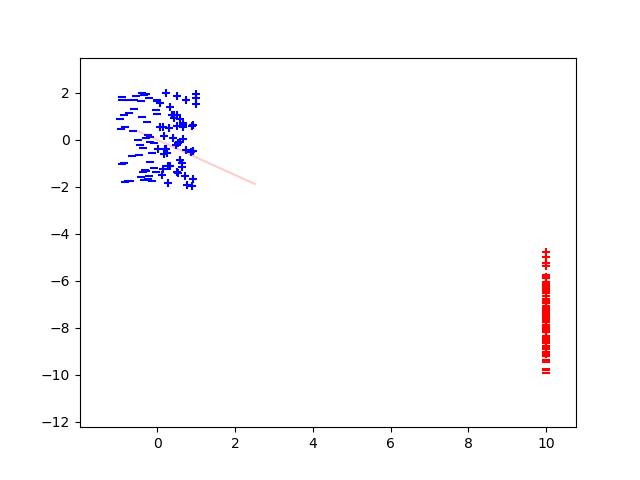

In [23]:
print(strategic_model_not_flex.w)
visualize_strategic_data(Xval, Xval_opt_not_flex, Yval, strategic_model_not_flex.w, strategic_model_not_flex.b, strategic_model_not_flex.v, torch.zeros(1))

Parameter containing:
tensor([ 1.4378, -0.2290], requires_grad=True)


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


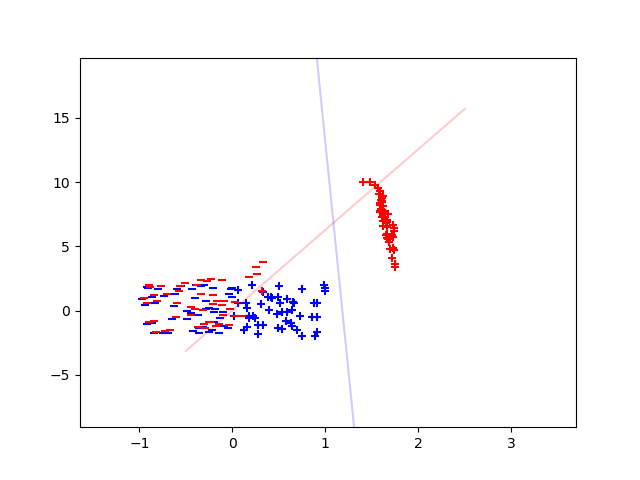

In [22]:
print(strategic_model_flex.v)
visualize_strategic_data(Xval, Xval_opt_flex, Yval, strategic_model_flex.w, strategic_model_flex.b, strategic_model_flex.v, torch.zeros(1))